In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.interpolate import interp1d
from matplotlib.image import imread
from matplotlib.pyplot import imshow

# Questão 1

## Item a

In [ ]:
def francis(A,tol):
  # Inicializar a matriz V, que será multiplicada a cada iteração
  V = np.eye(np.shape(A)[0])

  # Inicilizar a matriz B
  B = A

  # Inicializar o erro como infinito para a primeira iteração
  erro = float('inf')

  while erro>tol:

    # Decompor a matrix B_i em Q_i e R_i
    Q, R = np.linalg.qr(B)

    # Calcular a matrix B_{i+1}
    B = np.dot(R, Q)

    # Melhorar a matrix quase diagonal V
    V = np.dot(V, Q)

    # Calcular o maior elemento de B_{i+1} fora da diagonal principal
    erro = np.max(abs(np.tril(B,-1)))

  # A diagonal de B é uma aproximação dos autovalores de B
  D = np.diag(B)

  return V, D

## Item b

Pela definição do SVD, $A = U\Sigma V^T$. Como $V$ é uma matriz ortogonal, $V^T=V^{-1}$, então $AV = U\Sigma$. Como $\Sigma$ é uma matriz diagonal com elementos não nulos na diagonal principal, seu inverso existe, logo $AV\Sigma^{-1} = U$. Desse modo, pode-se obter U a partir das matrizes $A$, $V$ e $\Sigma$, sem a necessidade de realizar um segundo método de Francis.

In [ ]:
def svd(A):
  # Aplicar o método de Francis em A^T * A com tolerância 10^{-3}
  V, D = francis(A.T @ A, 1e-3)

  # Montar a matriz sigma do SVD com os autovalores de A^T * A
  (m, n) = np.shape(A)
  S = np.zeros((m, n))
  k = min(m, n)
  S[0:k,0:k] = np.diag(np.sqrt(np.abs(D)))

  # Obter U a partir de A, V e Sigma
  U = A @ V @ np.linalg.inv(S)

  return U, S, V

## Item c

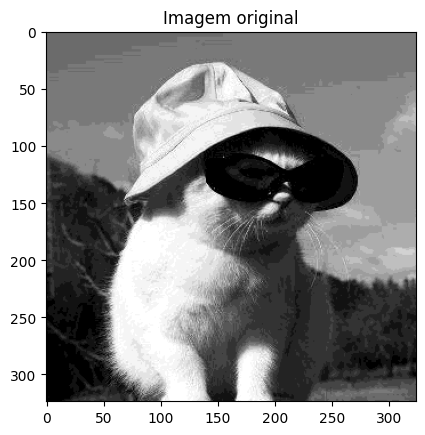

In [ ]:
# Carregar a imagem
img = imread('cat.png')

# Converter para um array do numpy
img = np.array(img)

# Exclui o último canal de cada pixel (que é 1.0 em todos), deixando apenas os 3 canais RGB
img = np.delete(img, 3, 2)

# Faz a média dos 3 canais para deixar cada pixel com apenas um valor de cinza entre 0 e 1
img = np.mean(img, 2)

# Mostra a imagem
plt.title('Imagem original')
plt.imshow(img, cmap='gray')
plt.show()

In [ ]:
def compact_image_np(img, porcentage):
  n = int(img.shape[0] * (1-porcentage))

  u, s, v = np.linalg.svd(img)
  s = np.diag(s)
  s_reduced = np.zeros(np.shape(img))
  for i in range(n):
      s_reduced[i,i] = s[i, i]

  reconstructed_img = u @ s_reduced @ v
  return reconstructed_img

In [ ]:
def compact_image_implemented(img, porcentage):
  n = int(img.shape[0] *  (1-porcentage))

  u, s, v = svd(img)
  s_reduced = np.zeros(np.shape(img))
  for i in range(n):
      s_reduced[i,i] = s[i, i]

  reconstructed_img = u @ s_reduced @ v.T
  return reconstructed_img

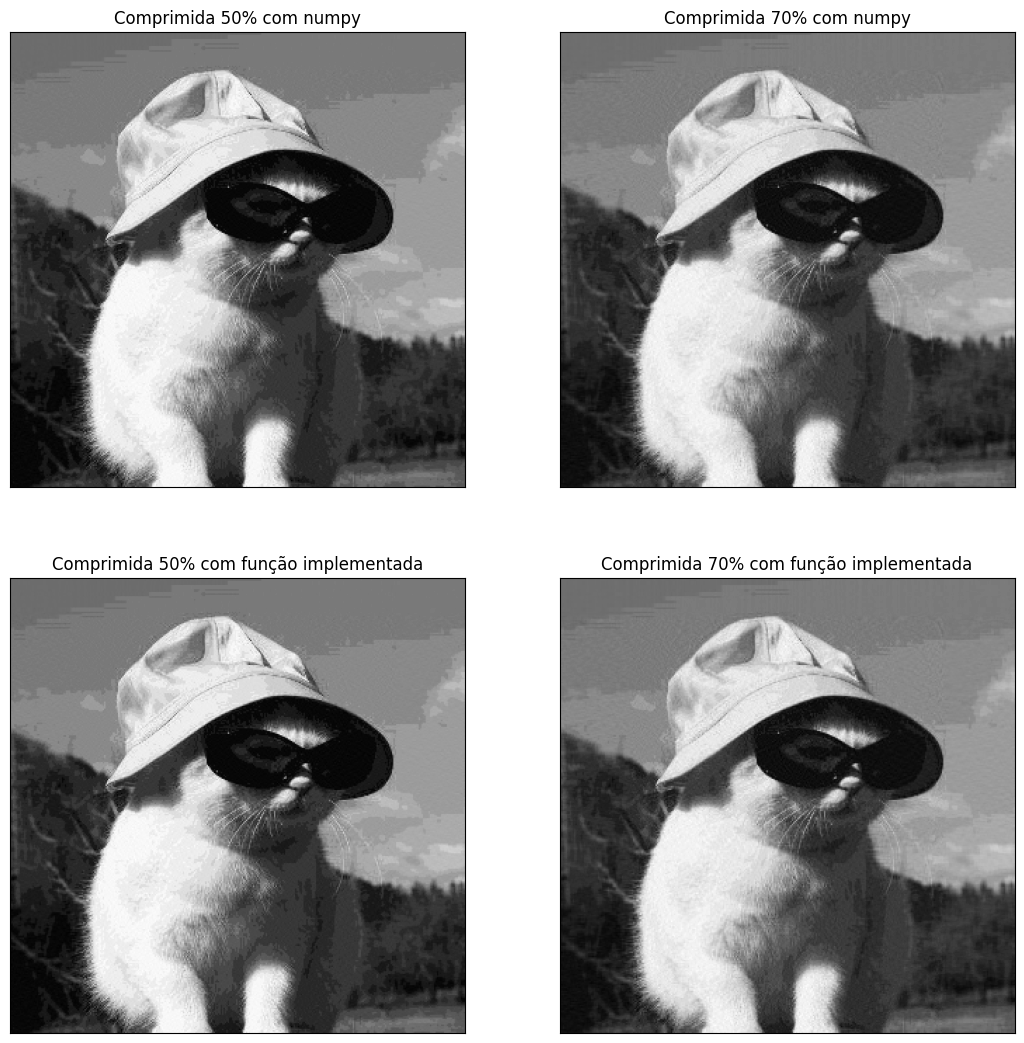

In [ ]:
compacted_img_np_50 = compact_image_np(img, 0.5)
compacted_img_np_70 = compact_image_np(img, 0.7)

compacted_img_implemented_50 = compact_image_implemented(img, 0.5)
compacted_img_implemented_70 = compact_image_implemented(img, 0.7)

figure, axis = plt.subplots(2, 2)

axis[0][0].set_title('Comprimida 50% com numpy')
axis[0][0].imshow(compacted_img_np_50, cmap='gray')
axis[0][0].get_xaxis().set_visible(False)
axis[0][0].get_yaxis().set_visible(False)

axis[0][1].set_title('Comprimida 70% com numpy')
axis[0][1].imshow(compacted_img_np_70, cmap='gray')
axis[0][1].get_xaxis().set_visible(False)
axis[0][1].get_yaxis().set_visible(False)

axis[1][0].set_title('Comprimida 50% com função implementada')
axis[1][0].imshow(compacted_img_implemented_50, cmap='gray')
axis[1][0].get_xaxis().set_visible(False)
axis[1][0].get_yaxis().set_visible(False)

axis[1][1].set_title('Comprimida 70% com função implementada')
axis[1][1].imshow(compacted_img_implemented_70, cmap='gray')
axis[1][1].get_xaxis().set_visible(False)
axis[1][1].get_yaxis().set_visible(False)

figure.set_size_inches(13, 13)

plt.show()

# Questão 2

## Item a

In [ ]:
def lagrange(xi, yi, x):
    # n é o número de pontos da amostra
    n = np.shape(xi)[0]

    # L é o polinômio de Lagrange
    L = np.ones((n, np.shape(x)[0]))

    # Calcula o polinômio de Lagrange de acordo com a fórmula
    for i in range(n):
        for j in range(n):
            if i != j:
                L[i, :] *= (x - xi[j]) / (xi[i] - xi[j])

    # Calcula o polinômio de interpolação
    y = np.dot(yi, L)

    return y

In [ ]:
def newton(xi, yi, x):
    # n é o número de pontos da amostra
    n = np.shape(xi)[0]

    # ni é o número de pontos em que quer se calcular o polinômio de interpolação
    ni = np.shape(x)[0]

    # D é a matrix das diferenças divididas
    D = np.zeros((n, n))

    # Diferenças divididas de ordem 0
    D[:, 0] = yi

    # Diferenças divididas de ordens superiores
    for j in range(1, n):
        for i in range(0, n-j):
            D[i, j] = (D[i, j-1] - D[i+1, j-1])
            D[i, j] /= (xi[i] - xi[i+j])

    # N são os termos do polinômio de Newton
    N = np.ones((n, ni))

    # Calcula os termos do polinômio de Newton
    for i in range(1, n):
        N[i, :] = N[i - 1, :] * (x - xi[i - 1])

    # Multiplica os coeficientes das diferenças divididas pelos termos do polinômio de Newton e soma-os
    y = np.dot(D[0, :], N)

    return y

## Item b

In [ ]:
def mostrar_graficos_lagrange_newton(pontos, imagens):

  pontos_amostra = np.linspace(-1, 1, 100)
  imagens_amostra = list(map(f, pontos_amostra))

  figura, axis = plt.subplots(1, 3)

  axis[0].set_title(f'Lagrange com {len(pontos)} pontos')
  axis[0].plot(pontos_amostra, imagens_amostra, color='green')
  axis[0].plot(pontos_amostra, lagrange(pontos, imagens, pontos_amostra), color='red')

  axis[1].set_title(f'Newton com {len(pontos)} pontos')
  axis[1].plot(pontos_amostra, imagens_amostra, color='green')
  axis[1].plot(pontos_amostra, newton(pontos, imagens, pontos_amostra), color='blue')

  axis[2].set_title(f'Newton e Lagrange com {len(pontos)} pontos')
  axis[2].plot(pontos_amostra, imagens_amostra, color='green')
  axis[2].plot(pontos_amostra, lagrange(pontos, imagens, pontos_amostra), color='red')
  axis[2].plot(pontos_amostra, newton(pontos, imagens, pontos_amostra), color='blue')

  figura.set_size_inches(15, 5)

  plt.show()

In [ ]:
def f(x):
  return 1 / (1+25*x*x)

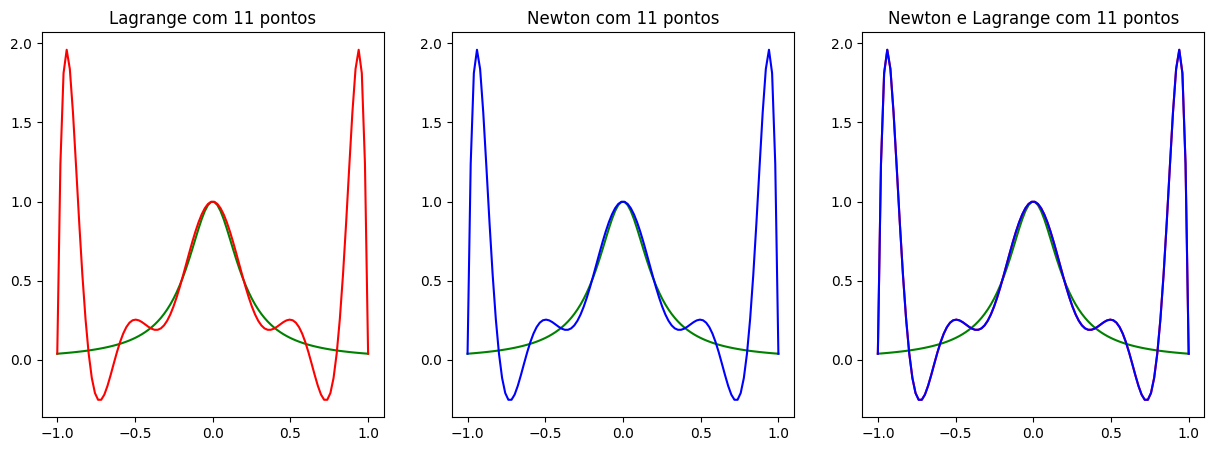

In [ ]:
pontos_11 = np.linspace(-1, 1, 11)
imagens_11 = list(map(f, pontos_11))

mostrar_graficos_lagrange_newton(pontos_11, imagens_11)

Percebe-se pelo último gráfico que as soluções encontradas são iguais. Isso se deve pelo fato das interpolações de Lagrange e Newton ambas encontram o polinômio de interpolação de grau $k$ com $n$ pontos de amostra, que é único.

## Item c

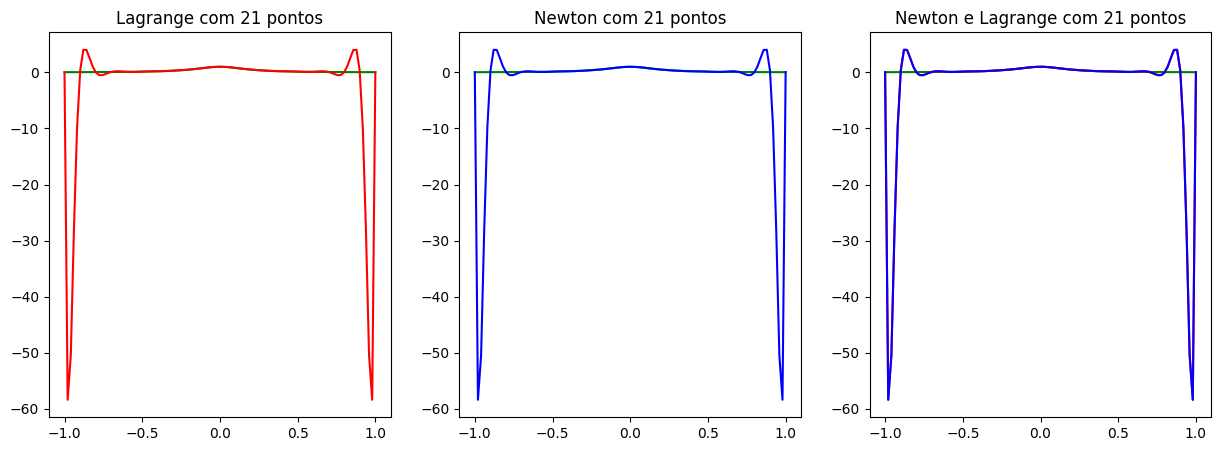

In [ ]:
pontos_21 = np.linspace(-1, 1, 21)
imagens_21 = list(map(f, pontos_21))

mostrar_graficos_lagrange_newton(pontos_21, imagens_21)

Ao adicionar mais pontos, o polinômio de interpolação começa a oscilar mais nos extremos do intervalo para garantir que todos os pontos de dados sejam conectados. Isso pode ser observado nos gráficos do polinômio gerado com 21 pontos de amostras em escala muito maior do que nos gráficos do polinômio gerado com apenas 11, embora o fenômeno ocorra em ambos.

## Item d

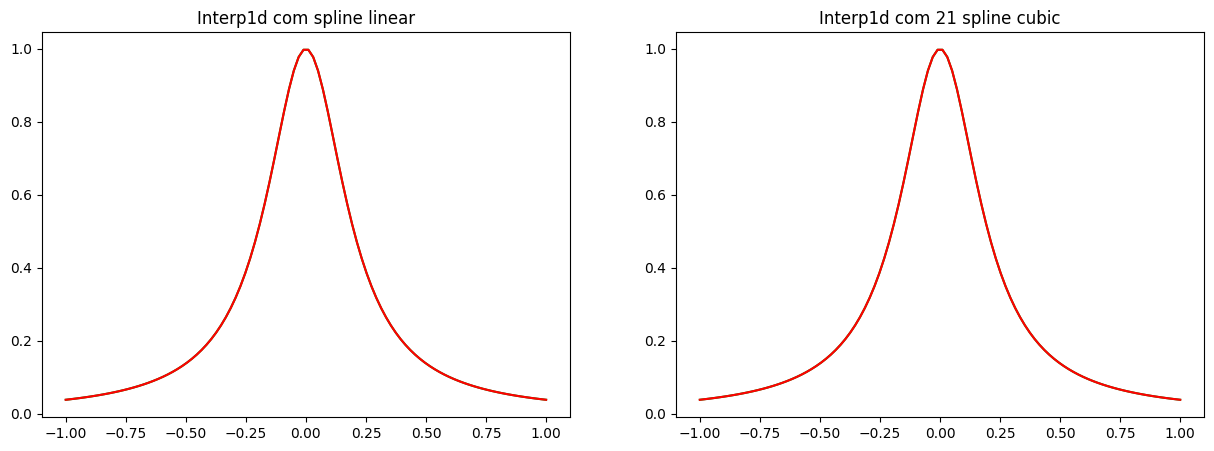

In [ ]:
pontos_amostra = np.linspace(-1, 1, 100)
imagens_amostra = list(map(f, pontos_amostra))

polinomio_linear = interp1d(pontos_amostra, imagens_amostra, kind='linear')
polinomio_cubic = interp1d(pontos_amostra, imagens_amostra, kind='cubic')

figura, axis = plt.subplots(1, 2)

axis[0].set_title('Interp1d com spline linear')
axis[0].plot(pontos_amostra, imagens_amostra, color='green')
axis[0].plot(pontos_amostra, polinomio_linear(pontos_amostra), color='red')

axis[1].set_title('Interp1d com 21 spline cubic')
axis[1].plot(pontos_amostra, imagens_amostra, color='green')
axis[1].plot(pontos_amostra, polinomio_cubic(pontos_amostra), color='red')

figura.set_size_inches(15, 5)

plt.show()

A interpolação usando splite, tanto linear quanto cúbica, se aproximou muito mais da função original que gerou os pontos de amostra, sem as oscilações nos extremos do intervalo como observado nos itens anteriores. Também, por não ser uma função com muitas curvaturas abruptas, não foi possível identificar visualmente diferenças na suavidade do splite cúbico para o linear.

## Item e

In [ ]:
def chebyshev(a, b, n):
  x = []
  for i in range(n):
    x.append(((a+b)/2) + ((b-a)/2)*math.cos(math.pi*(2*i + 1)/(2*(n+1))))
  return np.array(x)

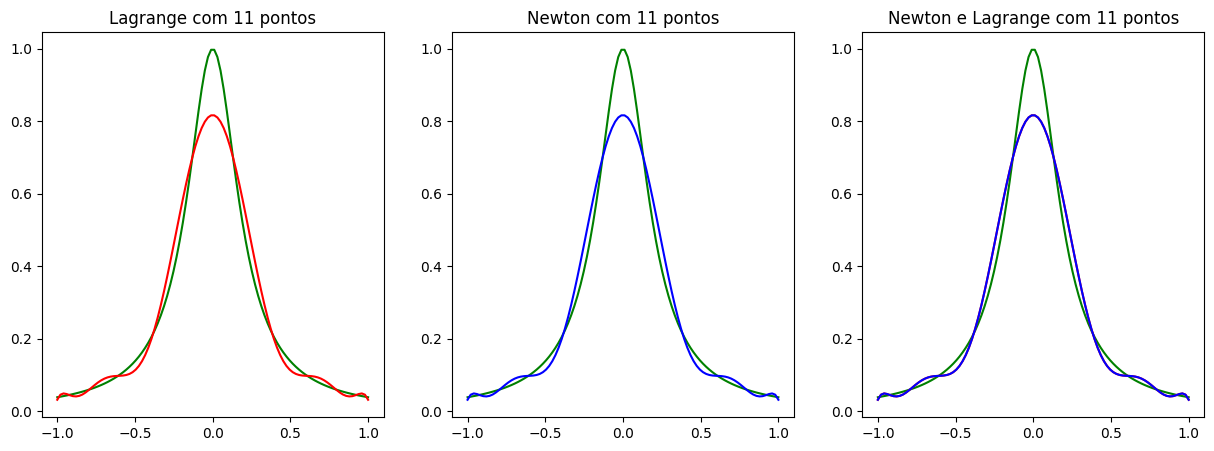

In [ ]:
pontos_11_chebyshev = chebyshev(-1, 1, 11)
imagens_11_chebyshev = list(map(f, pontos_11_chebyshev))

mostrar_graficos_lagrange_newton(pontos_11_chebyshev, imagens_11_chebyshev)

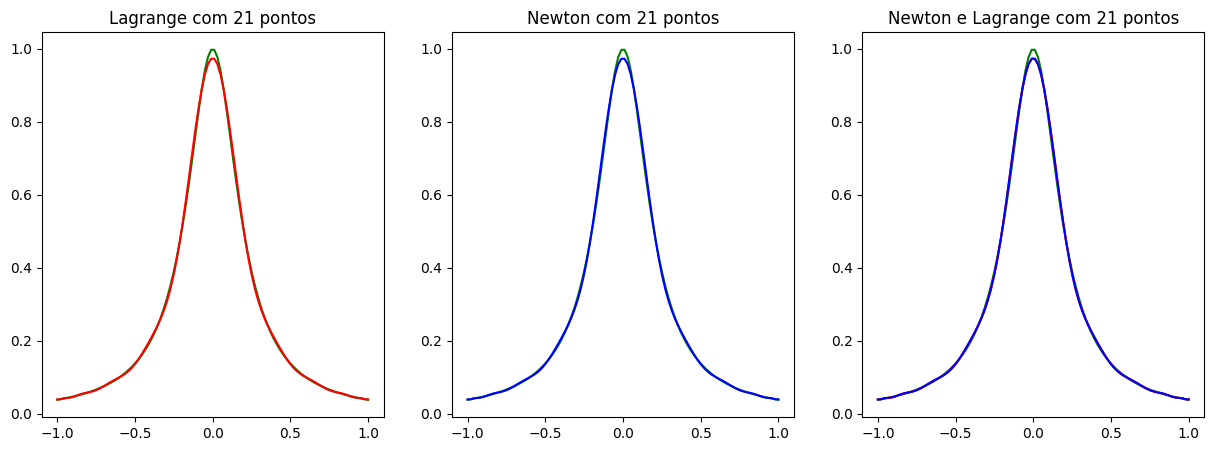

In [ ]:
pontos_21_chebyshev = chebyshev(-1, 1, 21)
imagens_21_chebyshev = list(map(f, pontos_21_chebyshev))

mostrar_graficos_lagrange_newton(pontos_21_chebyshev, imagens_21_chebyshev)

Percebe-se que a escolha dos pontos de amostra com nós de Chebyskev mitigou o problema de oscilação que foi observado nos itens b) e c), pois os pontos não são mais distribuidos linearmente, mas sim mais concentrados nas extremidades do intervalo. Além disso, com o aumento da quantidade de pontos de amostras, o problema da oscilação foi reduzido, não intensificado.

# Questão 3

## Item a

A função $\texttt{mmq}$ calcula os $k$ coeficientes de um polinômio de grau $k-1$ que melhor se ajusta, pelo método dos mínimos quadrados, a um conjunto de $n$ pontos, cujas coordenas são dadas nos vetores $x$ e $y$. Para tal, deve-se resolver o sistema $X^TX\alpha^* = X^Ty$, encontrando o vetor de coeficientes $\alpha^*$, onde $X$ é uma matriz de Vandermonde de dimensão $n \times k$ em que cada linha representa um ponto do conjunto. Ou seja, se $x = [x_1, x_2, \dots, x_n]$,

$$
X =
\begin{bmatrix}
1 & x_1 & x_1^2 & \dots & x_1^{k-1} \\
1 & x_2 & x_2^2 & \dots & x_2^{k-1} \\
&&& vdots  &  \\
1 & x_n & x_n^2 & \dots & x_n^{k-1}
\end{bmatrix}
$$

No código, após calcular a matrix $X$ com a função $\texttt{np.vander}$, usa-se $A := X^TX$ e $b:=X^Ty$, de modo que $A\alpha^* = b$, e resolve-se o sistema com a função $\texttt{np.linalg.solve}$.



In [ ]:
def mmq(x, y, k):
  '''
  Calcula os k coeficientes de um polinômio de grau k-1 que melhor se ajusta, pelo método dos mínimos quadrados, a um conjunto de pontos.
  '''

  # Calcular a matriz X
  X = np.vander(x, k)

  # Calcular a matrix A
  A = np.transpose(X).dot(X)

  # Calcular o vetor b
  b = np.transpose(X).dot(y)

  # Resolver o sistema para encontrar os coeficientes
  a = np.linalg.solve(A, b)

  return a

A função $\texttt{mmq_QR}$ tem a mesma aplicação da função $\texttt{mmq}$, porém utiliza a decomposição QR da matriz $X$ para facilitar a resolução do sistema. Se $Q$ e $R$ são as matrizes da decomposição QR de $X$, então $Q$ é uma matriz ortogonal de dimensão $k \times k$ e $R$ é uma matriz triangular superior de dimensão $k \times n$, pode-se calcular $\alpha^*$ pelo sistema $R\alpha^* = Q^Ty$.

No código, após calcular a matrix $X$ com a função $\texttt{np.vander}$, calcula-se $Q$ e $R$ com a função $\texttt{np.linalg.qr}$ e usa-se $b:=Q^Ty$, de modo que $R\alpha^* = b$. Por fim, resolveu-se o sistema com a função $\texttt{np.linalg.solve}$.



In [ ]:
def mmq_QR(x, y, k):
  '''
  Calcula os k coeficientes de um polinômio de grau k-1 que melhor se ajusta, pelo método dos mínimos quadrados, a um conjunto de pontos.
  Utiliza a decomposição QR para otimização.
  '''

  # Calcular a matriz X
  X = np.vander(x, k)

  # Calcular as matrizes Q e R
  (Q, R) = np.linalg.qr(X)

  # Calcular o vetor b
  b = np.transpose(Q).dot(y)

  # Resolver o sistema para encontrar os coeficientes
  a = np.linalg.solve(R, b)
  return a

## Item b

### Casos acumulados

In [ ]:
casos_acumulados = [
    1,
    1,
    1,
    2,
    2,
    2,
    2,
    3,
    7,
    13,
    19,
    25,
    25,
    34,
    52,
    77,
    98,
    121,
    200,
    234,
    291,
    428,
    621,
    904,
    1128,
    1546,
    1891,
    2201,
    2433,
    2915,
    3417,
    3903,
    4256,
    4579,
    5717,
    6834,
    7910,
    9056,
    10278,
    11130,
    12056,
    13717,
    15927,
    17857,
    19638,
    20727,
    22169,
    23430,
    25262,
    28320,
    30425,
    33682,
    36599,
    38654,
    40581,
    43079,
    45757,
    49492,
    52995,
    58509,
    61888,
    66501,
    71886,
    78162,
    85380,
    91299,
    96396,
    101147,
    107780,
    114715,
    125218,
    135106,
    145328,
    155939,
    162699,
    168331,
    177589,
    188974,
    202918,
    218223,
    233142,
    241080,
    254220,
    271628,
    291579,
    310087,
    330890,
    347398,
    363211,
    374898,
    391222,
    411821,
    438238,
    465166,
    498440,
    514200,
    526447,
    555383,
    584016,
    614941,
    645771,
    672846,
    691758,
    707412,
    739503,
    772416,
    802828,
    828810,
    850514,
    867624,
    888271,
    923189,
    955377,
    978142,
    1032913,
    1067579,
    1085038,
    1106470
]

### Resolução

Temos $y_i = g(x_i) = ab^{x_i}$, para $1 \leq i \leq n$. Então $\log |y_i| = \log |ab^{x_i}| = \log |a| + \log |b^{x_i}| = \log |a| + x_i\log |b|$. Assim, pode-se estimar $\log |a|$ e $\log |b|$ pelo método dos mínimos quadrados como os coeficientes de um polinômio de grau 1 que aproxima os pontos $(x_i, \log |y_i|)$, $1 \leq i \leq n$,

O valor aproximado de a é 35.313 e de b é 1.1114.


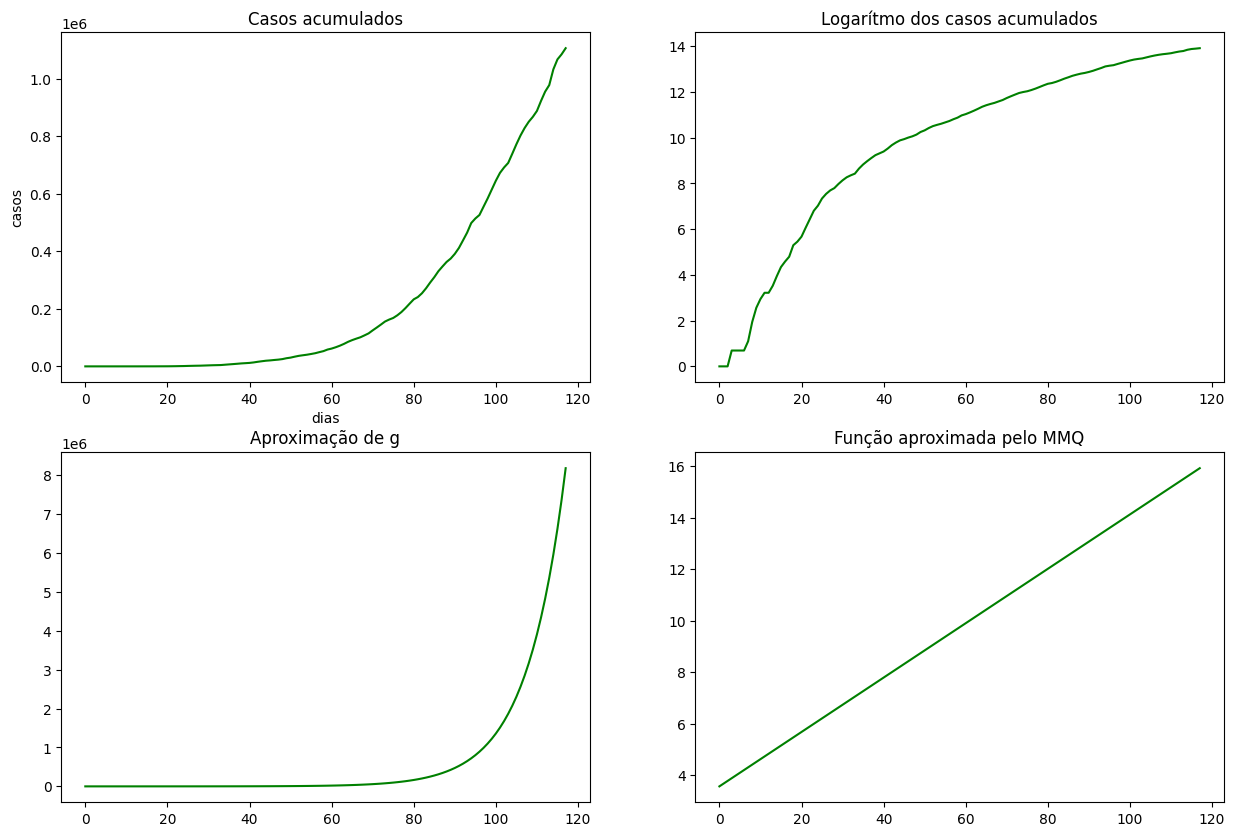

In [ ]:
def aproximar_coeficientes_de_g(casos_acumulados):
  # Número do coeficientes do polinômio aproximado
  k = 2

  # x representa os dias dos pontos de amostra
  x = range(len(casos_acumulados))
  # Os valores de y já são poisitivos, não há necessidade de aplicar o módulo
  y = [math.log(casos) for casos in casos_acumulados]
  coeficientes = mmq_QR(x, y, k)

  # Calcular a e b a partir dos coeficientes aproximados pelo MMQ
  log_a = coeficientes[1]
  log_b = coeficientes[0]
  a = abs(math.exp(log_a))
  b = abs(math.exp(log_b))

  print(f"O valor aproximado de a é {round(a, 4)} e de b é {round(b, 4)}.")

  # Calcular g e a função aproximada para plotagem
  g = [a*(b**xi) for xi in x]
  aproximacao_mmq = [log_a + log_b*xi for xi in x]

  figura, axis = plt.subplots(2, 2)

  axis[0][0].set_title(f'Casos acumulados')
  axis[0][0].set_xlabel('dias')
  axis[0][0].set_ylabel('casos')
  axis[0][0].plot(x, casos_acumulados, color='green')

  axis[0][1].set_title(f'Logarítmo dos casos acumulados')
  axis[0][0].set_xlabel('dias')
  axis[0][0].set_ylabel('casos')
  axis[0][1].plot(x, y, color='green')

  axis[1][0].set_title(f'Aproximação de g')
  axis[1][0].plot(x, g, color='green')

  axis[1][1].set_title(f'Função aproximada pelo MMQ')
  axis[1][1].plot(x, aproximacao_mmq, color='green')

  figura.set_size_inches(15, 10)

  plt.show()

aproximar_coeficientes_de_g(casos_acumulados)

## Item c

O valor aproximado de a é 0.5965 e de b é 1.3717.


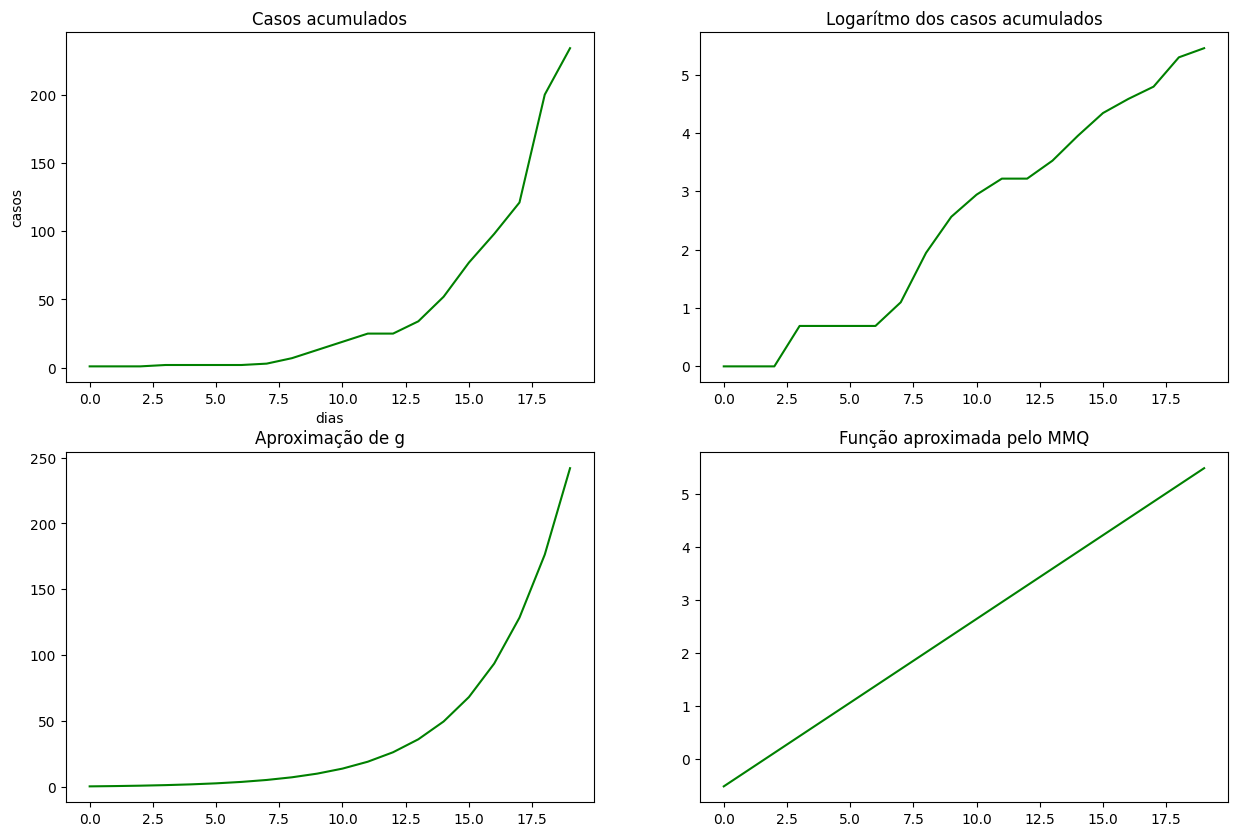

In [ ]:
aproximar_coeficientes_de_g(casos_acumulados[0:20])

## Item d

O valor aproximado de a é 128288.831 e de b é 1.0488.


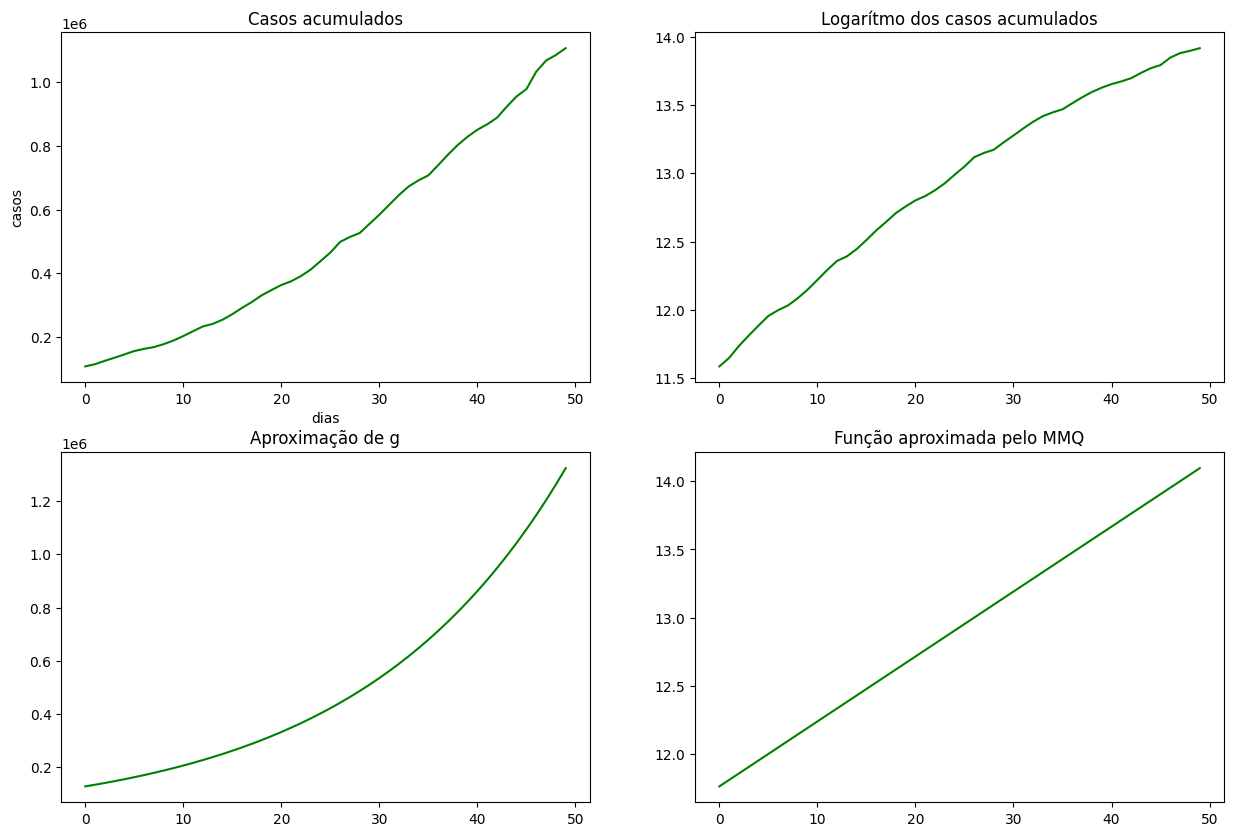

In [ ]:
aproximar_coeficientes_de_g(casos_acumulados[-50:])

## Item e

Percebe-se que o valor de b é ligeiramente maior na aproximação apenas com os 20 primeiros dias do que na aproximação apenas com os 50 últimos dias, sendo que o valor obtido com todos os dias é intermediário. Isso indica que os casos acumulados têm uma taxa de crescimento exponencial maior no início do período, e o crescimento é levemente suavizado no final do período. Acontece o inverso com o valor de a, sendo menor na aproximação apenas com os 20 primeiros dias do que na aproximação com os 50 últimos dias, sendo que o valor obtido com todos os dias é intermediário. Isso indica que no os casos acumulados do final do perído se aproximam mais de um crescimento linear e no começo do perído se aproximam mais de um crescimento exponencial.